In [3]:
# Analysis imports
import numpy as np
import pandas as pd
from scipy import special
from random import sample

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling imports
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import f1_score

# Miscellaneous imports
import itertools
from datetime import timedelta
from IPython.display import display

# Miscellaneous settings
pd.options.display.max_seq_items = 2000

In [4]:
# Read in fraud data
fraud_df = pd.read_csv("Fraud_Data/Fraud_Data.csv", header=0)

# Read in ISP data
ISP_df = pd.read_csv("Fraud_Data/IpAddress_to_Country.csv", header=0)

In [6]:
for col in fraud_df.columns:
    print(col, fraud_df[col].dtype)

user_id int64
signup_time object
purchase_time object
purchase_value int64
device_id object
source object
browser object
sex object
age int64
ip_address float64
class int64


In [9]:
# Check for nulls
print("Check for null values")
for col in fraud_df.columns:
    print(col, fraud_df[col].isnull().sum())

Check for null values
user_id 0
signup_time 0
purchase_time 0
purchase_value 0
device_id 0
source 0
browser 0
sex 0
age 0
ip_address 0
class 0


In [10]:
fraud_df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [12]:
for col in ISP_df.columns:
    print("{}: {}".format(col, ISP_df[col].dtype))

lower_bound_ip_address: float64
upper_bound_ip_address: int64
country: object


In [14]:
ip_floats = ISP_df.lower_bound_ip_address.apply(lambda x: not x.is_integer()).sum()
print("Number of non-zero decimal ip address lower bounds: {}".format(ip_floats))

Number of non-zero decimal ip address lower bounds: 0


In [15]:
ISP_df.lower_bound_ip_address = ISP_df.lower_bound_ip_address.astype(int)

In [18]:
# Check for nulls
print("Check for null values")
for col in ISP_df.columns:
    print("# of null values in {}: {}".format(col, ISP_df[col].isnull().sum()))

Check for null values
# of null values in lower_bound_ip_address: 0
# of null values in upper_bound_ip_address: 0
# of null values in country: 0


In [19]:
ISP_df.describe()

,lower_bound_ip_address,upper_bound_ip_address
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [20]:
display(ISP_df[ ISP_df.lower_bound_ip_address == ISP_df.lower_bound_ip_address.max() ])
display(ISP_df[ ISP_df.upper_bound_ip_address == ISP_df.upper_bound_ip_address.max() ])

,lower_bound_ip_address,upper_bound_ip_address,country
138845,3758096128,3758096383,Australia


,lower_bound_ip_address,upper_bound_ip_address,country
138845,3758096128,3758096383,Australia


In [22]:
def isp_counts(isp):
    country = ISP_df[(ISP_df.lower_bound_ip_address <= isp) & (ISP_df.upper_bound_ip_address >= isp)].country
    if country.shape[0] == 1:
        return "Unique"
    elif country.shape[0] > 1:
        return "Multiple countries"
    elif country.shape[0] == 0:
        if isp > ISP_df.upper_bound_ip_address.max():
            return "Too big"
        elif isp < ISP_df.lower_bound_ip_address.min():
            return "Too small"
        else:
            return "Missing from the middle"
        
ip_counts = fraud_df.ip_address.apply(isp_counts)
ip_counts.value_counts()

Unique                     129146
Too big                     19383
Missing from the middle      1949
Too small                     634
Name: ip_address, dtype: int64

In [23]:
def ip_to_country(ip):
    tmp_ser = ISP_df[ (ISP_df.lower_bound_ip_address <= ip) 
                    & (ISP_df.upper_bound_ip_address >= ip) ].country
    if tmp_ser.shape[0] == 1:
        return tmp_ser.iloc[0]
    elif tmp_ser.shape[0] < 1:
        return "Missing"
    elif tmp_ser.shape[0] > 1:
        return "Error"
    
fraud_df["country"] = fraud_df.ip_address.apply(ip_to_country)

In [24]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Missing
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [25]:
fraud_df.to_csv("Fraud_Data/Fraud_Data_with_Countries.csv", index=False)

Text(0, 0.5, 'Counts')

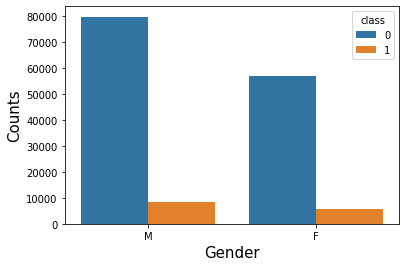

In [26]:
sns.countplot(x='sex', hue='class', data=fraud_df)
plt.xlabel("Gender", fontsize=15)
plt.ylabel("Counts", fontsize=15)

Next, I explore the relationship between purchase value and fraud. Although there is a slight increase in the average purchase value associated with fraudulent activity, the errors bars are far too high to spot a real trend.

/home/mini/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.42499999999999716, 0.5, 'Purchase Value')

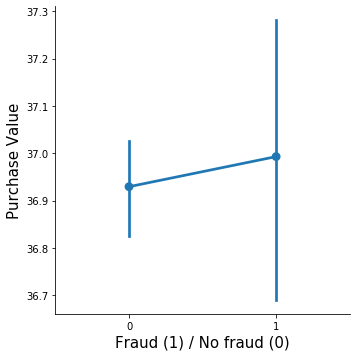

In [27]:
sns.factorplot(x="class", y="purchase_value", data=fraud_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("Purchase Value", fontsize=15)

/home/mini/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(-5.825000000000003, 0.5, 'Age')

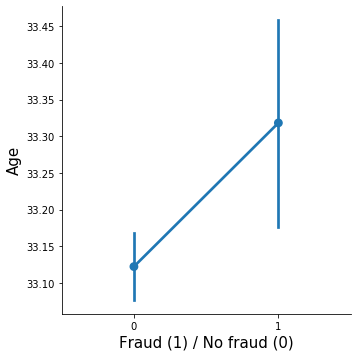

In [28]:
sns.factorplot(x="class", y="age", data=fraud_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("Age", fontsize=15)

Text(0, 0.5, 'Counts')

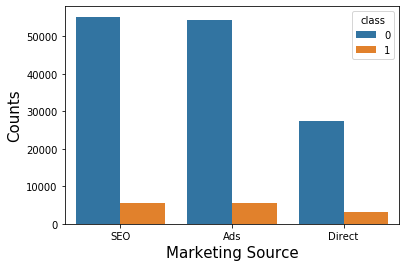

In [29]:
sns.countplot(x='source', hue='class', data=fraud_df)
plt.xlabel("Marketing Source", fontsize=15)
plt.ylabel("Counts", fontsize=15)

Text(0, 0.5, 'Counts')

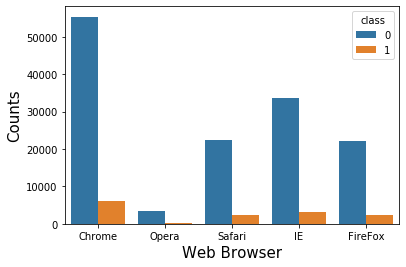

In [30]:
sns.countplot(x='browser', hue='class', data=fraud_df)
plt.xlabel("Web Browser", fontsize=15)
plt.ylabel("Counts", fontsize=15)

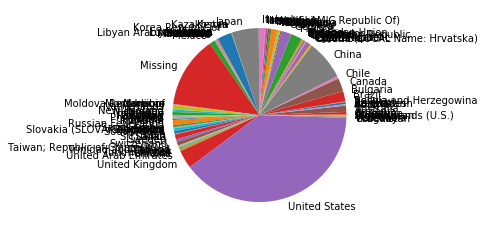

In [31]:
sums = fraud_df[fraud_df["class"] == 1]["class"].groupby(fraud_df.country).sum()
plt.axis('equal')
plt.pie(sums, labels=sums.index)
plt.show()

/home/mini/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/mini/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(16.299999999999997, 0.5, 'User ids per IP Address')

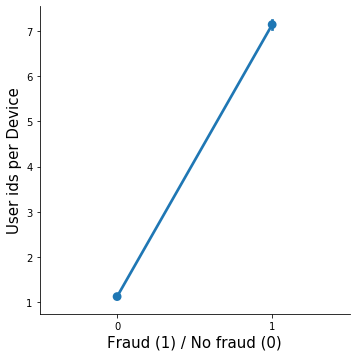

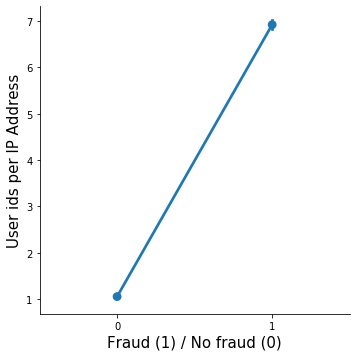

In [32]:
# Initialize a new dataframe
tmp_df = pd.DataFrame(columns=("class", "userids_per_deviceid", "userids_per_ipaddress"))
tmp_df["class"] = fraud_df["class"]

# Count the number of unique user ids associated each device
userid_count = fraud_df.groupby("device_id").user_id.count()
tmp_df["userids_per_deviceid"] = fraud_df.device_id.apply(lambda x: userid_count[x])

# Count the number of unique user ids associated each ip address
userid_count = fraud_df.groupby("ip_address").user_id.count()
tmp_df["userids_per_ipaddress"] = fraud_df.ip_address.apply(lambda x: userid_count[x])

sns.factorplot(x="class", y="userids_per_deviceid", data=tmp_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("User ids per Device", fontsize=15)

sns.factorplot(x="class", y="userids_per_ipaddress", data=tmp_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("User ids per IP Address", fontsize=15)

/home/mini/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(-8.825000000000003, 0.5, 'Sign-up to Purchase Time (Seconds)')

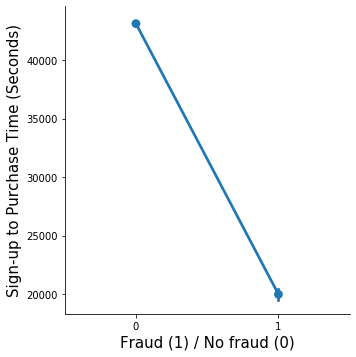

In [33]:
# Convert sign-up time and purchase time to datetime objects
tmp_df["signup_time"] = fraud_df.signup_time.apply(pd.to_datetime)
tmp_df["purchase_time"] = fraud_df.purchase_time.apply(pd.to_datetime)

# Add columns for the number of seconds between purchase and sign-up times
tmp_df["signup_to_purchase_seconds"] = (tmp_df.purchase_time - tmp_df.signup_time).apply(lambda x: x.seconds)

sns.factorplot(x="class", y="signup_to_purchase_seconds", data=tmp_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("Sign-up to Purchase Time (Seconds)", fontsize=15)

Text(0, 0.5, 'Count')

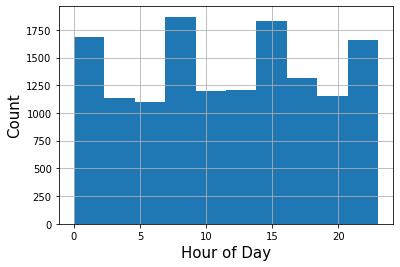

In [34]:
tmp_df[tmp_df["class"] == 1].signup_time.apply(lambda x: x.hour).hist()
plt.xlabel("Hour of Day", fontsize=15)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

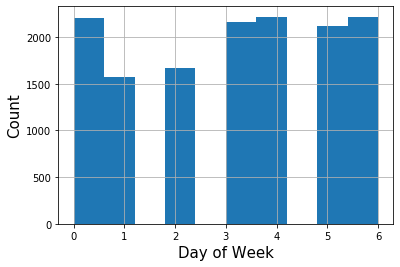

In [35]:
tmp_df[tmp_df["class"] == 1].signup_time.apply(lambda x: x.dayofweek).hist()
plt.xlabel("Day of Week", fontsize=15)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

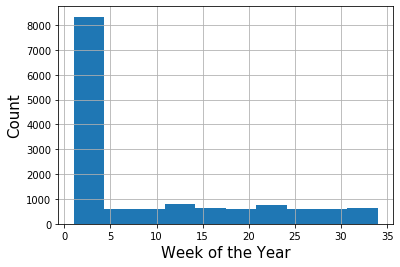

In [36]:
tmp_df[tmp_df["class"] == 1].signup_time.apply(lambda x: x.week).hist()
plt.xlabel("Week of the Year", fontsize=15)
plt.ylabel("Count", fontsize=15)

In [37]:
# First reload the dataset
fraud_df = pd.read_csv("Fraud_Data/Fraud_Data_with_Countries.csv", header=0)

# Add column corresponding to the number of unique user id's associated with the given device id
userid_count = fraud_df.groupby("device_id").user_id.count()
fraud_df["userids_per_deviceid"] = fraud_df.device_id.apply(lambda x: userid_count[x])

# Add column corresponding to the number of unique user id's associated with the given ip address
userid_count = fraud_df.groupby("ip_address").user_id.count()
fraud_df["userids_per_ipaddress"] = fraud_df.ip_address.apply(lambda x: userid_count[x])

# Add column for the average of the previous two columns
fraud_df["mean_number_of_userids"] = (fraud_df.userids_per_deviceid + fraud_df.userids_per_ipaddress) * 0.5

# Convert sign-up time and purchase time to datetime objects
fraud_df.signup_time = fraud_df.signup_time.apply(pd.to_datetime)
fraud_df.purchase_time = fraud_df.purchase_time.apply(pd.to_datetime)

# Add columns for the number of seconds and days between purchase and sign-up times
fraud_df["signup_to_purchase_seconds"] = (fraud_df.purchase_time - fraud_df.signup_time).apply(lambda x: x.seconds)

# Create dummy columns for country feature
country_dummies = pd.get_dummies(fraud_df.country, prefix='country')
fraud_df = pd.concat([fraud_df, country_dummies], axis=1)

# Drop spurious columns
fraud_df.drop(["user_id", 
               "signup_time", 
               "purchase_time", 
               "device_id", 
               "ip_address", 
               "userids_per_deviceid",
               "userids_per_ipaddress",
               "country",
               "source",
               "browser",
               "sex",
               "age",
               "purchase_value"
               ], axis=1, inplace=True)

/home/mini/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


Text(0, 0.5, 'Normalized Count')

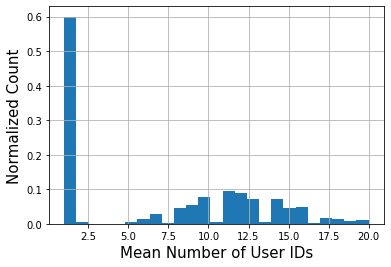

In [38]:
fraud_df[fraud_df["class"]==1].mean_number_of_userids.hist(normed=True, bins=25)
plt.xlabel("Mean Number of User IDs", fontsize=15)
plt.ylabel("Normalized Count", fontsize=15)

The signup_to_purchase_seconds feature is rather uniformly distributed.

Text(0, 0.5, 'Normalized Count')

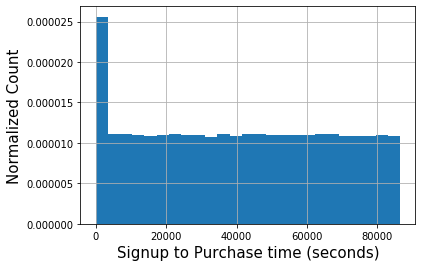

In [39]:
fraud_df.signup_to_purchase_seconds.hist(normed=True, bins=25)
plt.xlabel("Signup to Purchase time (seconds)", fontsize=15)
plt.ylabel("Normalized Count", fontsize=15)

Text(0, 0.5, 'Normalized Count')

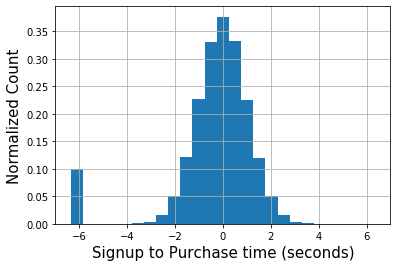

In [40]:
def rescale_series(ser):
    ser_min = ser.min() - 1e-5
    ser_max = ser.max() + 1e-5
    new_ser = (ser - ser_min) / (ser_max - ser_min)
    new_ser = new_ser.apply(lambda x: np.sqrt(2) * special.erfinv(2 * x - 1))
    return new_ser

fraud_df["signup_to_purchase_time"] = rescale_series(fraud_df.signup_to_purchase_seconds)
fraud_df.drop("signup_to_purchase_seconds", axis=1, inplace=True)
fraud_df.signup_to_purchase_time.hist(normed=True, bins=25)
plt.xlabel("Signup to Purchase time (seconds)", fontsize=15)
plt.ylabel("Normalized Count", fontsize=15)

In [41]:
def rescale_series(ser):
    ser_min = ser.min()
    ser_max = ser.max()
    new_ser = (ser - ser_min) / (ser_max - ser_min)
    return new_ser

# Get all column names that are not one-hot-encoded
non_onehotencoded_cols = [feature for feature in fraud_df.columns if "country" not in feature and feature != "class"]

# Rescale all non one-hot-encoded columns
for col in non_onehotencoded_cols:
    fraud_df[col] = rescale_series(fraud_df[col])

X = fraud_df[ [col for col in fraud_df.columns if col != "class"] ]
Y = fraud_df["class"]

In [42]:
# Create an instance of the extra trees classifier
clf = ExtraTreesClassifier(n_estimators=200)
_ = clf.fit(X, Y)

# Create a dataframe to map features to their importances
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_

# Print out important features
features[ features.importance > np.mean(features.importance) ].sort_values(by='importance', ascending=False)

,feature,importance
183,signup_to_purchase_time,0.704303
0,mean_number_of_userids,0.290385


Text(27.424667968750015, 0.5, 'Mean Number of User IDs')

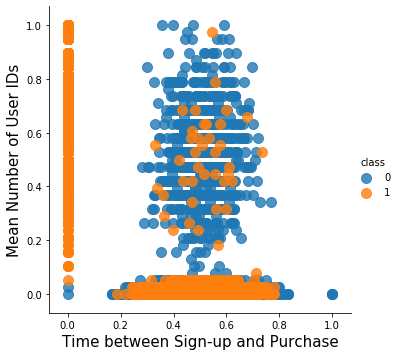

In [43]:
X = fraud_df[ [col for col in fraud_df.columns if "country" not in col and col != "class"] ]

sns.lmplot("signup_to_purchase_time", "mean_number_of_userids",
           data=pd.concat([X, Y], axis=1),
           fit_reg=False,
           hue="class",  
           scatter_kws={"marker": "D", "s": 100})
plt.xlabel('Time between Sign-up and Purchase', fontsize=15)
plt.ylabel('Mean Number of User IDs', fontsize=15)

In [44]:
X.index = range(len(X))
Y.index = range(len(Y))

In [45]:
# Split the data 
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X, Y, train_size=.75, random_state=23)
# The isolation forest returns values of 1 for normal and -1 for anomalous so I transform target values to match
Y_dev = Y_dev.apply(lambda x: 1 if x == 0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x == 0 else -1)

# Initiate the isolation forest class and specify the percentage of anomalous samples in the development dataset
IF = IsolationForest(max_samples="auto", contamination=0.095)

# Define the parameter grid to search over
param_grid = {"n_estimators": [100, 150, 200, 250, 300, 350, 400, 450, 500]}

# Define the grid search object
clf = GridSearchCV(IF, 
                   param_grid=param_grid, 
                   cv=5, 
                   n_jobs=10,
                   scoring="f1",
                   verbose=10)

# Perform grid search
_ = clf.fit(X_dev, Y_dev)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   22.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   48.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done  31 out of  45 | elapsed:  2.3min remaining:  1.1min
[Parallel(n_jobs=10)]: Done  36 out of  45 | elapsed:  2.7min remaining:   40.2s
[Parallel(n_jobs=10)]: Done  41 out of  45 | elapsed:  3.1min remaining:   18.3s
[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed:  3.2min finished


              precision    recall  f1-score   support

   anomalous       0.59      0.58      0.59      3546
      normal       0.96      0.96      0.96     34232

    accuracy                           0.92     37778
   macro avg       0.78      0.77      0.77     37778
weighted avg       0.92      0.92      0.92     37778

Area under ROC curve: 0.772


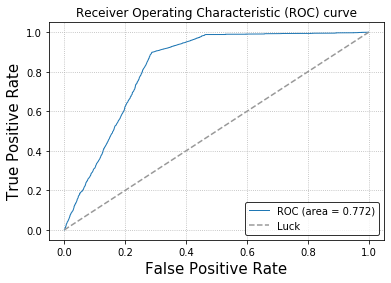

In [47]:
IF_best = clf.best_estimator_
Y_predicted = IF_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

print(classification_report(Y_eval, 
                            Y_predicted,
                            target_names=["anomalous", "normal"]))
print("Area under ROC curve: {:0.3f}".format(roc_auc))

# Compute ROC curve and area under the curve
IF_probs = IF_best.decision_function(X_eval)
fpr, tpr, thresholds = roc_curve(Y_eval, IF_probs)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.3f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) curve', fontsize=12)
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()

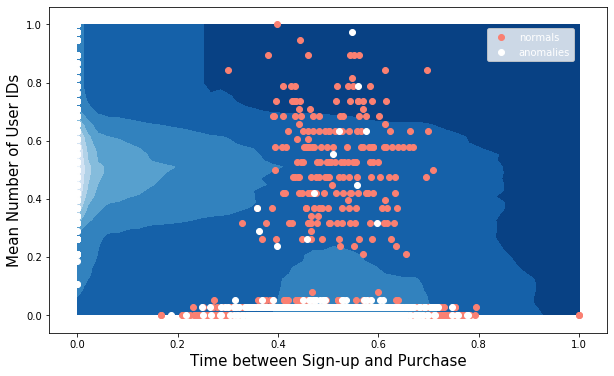

In [48]:
# Set figure size
plt.figure(figsize=(10,6))

# plot the contour lines
xx, yy = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
Z = IF_best.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

# Plot normal and anomalous data
plt.scatter(X_eval[Y_eval==1].signup_to_purchase_time, X_eval[Y_eval==1].mean_number_of_userids, 
            color="salmon", label="normals")
plt.scatter(X_eval[Y_eval==-1].signup_to_purchase_time, X_eval[Y_eval==-1].mean_number_of_userids, 
            color="white", label="anomalies")

# Set labels and legend
plt.xlabel('Time between Sign-up and Purchase', fontsize=15)
plt.ylabel('Mean Number of User IDs', fontsize=15)
for text in plt.legend(bbox_to_anchor=(.95, .95)).get_texts():
    text.set_color("white")

In [53]:
# Add the target vector back to the feature set
X["class"] = Y

# Separate the anomalies from the normals
X_anomalies = X[ X["class"] == 1 ]
X_normals = X[ X["class"] == 0 ]

# Randomly sample 70% of the indices of the normal dataset for training
train_idxs = sample(list(X_normals.index), int(0.7 * X_normals.shape[0]))
X_train = X_normals.loc[train_idxs]
# Keep the rest for the testing set
X_testing = X_normals.drop(train_idxs)
# The testing set should now be the combination of the remaining normal instances not in the training set
# and the anomaly instances
X_testing = pd.concat([X_testing, X_anomalies], axis=0)

# Shuffle the rows for both datasets
X_train = X_train.sample(frac=1).reset_index(drop=True)
X_testing = X_testing.sample(frac=1).reset_index(drop=True)

# Split the testing dataframe up into cross validation and evaluation datasets
Y_testing = X_testing["class"]
X_testing = X_testing[ [col for col in X_testing.columns if col != "class"] ]
X_cv, X_eval, Y_cv, Y_eval = train_test_split(X_testing, Y_testing, train_size=.7, random_state=23)

# Map Y_cv and Y_eval values to 1 (normal), -1 (anomalies) convention
Y_cv = Y_cv.apply(lambda x: 1 if x == 0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x == 0 else -1)

# Finally, drop the class column from the training set
X_train = X_train[ [col for col in X_testing.columns if col != "class"] ]

/home/mini/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
# Define the parameter grid to search over
param_grid = {"nu": np.linspace(0.001, .01, 5), "gamma": [0.01, .03, 0.1, 0.3]}
param_list = list(itertools.product(param_grid["nu"], param_grid["gamma"]))

def random_gridsearch(param_list, n_sample, X_train, X_cv, Y_cv):

    f1_max = 0
    param_list = sample(param_list, n_sample)
    remaining_fits = n_sample
    print("Performing {} fits...\n".format(remaining_fits))
    for params in param_list:
        # Initialize class and set hyperparameters
        nu, gamma = params
        OCSVM = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma)

        # Fit model
        print("Fitting model...")
        OCSVM.fit(X_train)

        # Calculate F1 score
        cv_preds = OCSVM.predict(X_cv)
        f1 = f1_score(Y_cv.values, cv_preds, average="binary")

        # Print results
        print("F1 score based on nu={0:.3f}, gamma={1:.2f}: {2:.3f}".format(nu, gamma, f1))

        # Optimize for F1 score
        if f1 > f1_max:
            f1_max = f1
            OCSVM_best = OCSVM

        remaining_fits -= 1
        print("{} fits remaining...".format(remaining_fits))
        
    return f1_max, OCSVM_best
        
f1_max, OCSVM_best = random_gridsearch(param_list, 10, X_train, X_cv, Y_cv)

Performing 10 fits...

Fitting model...
F1 score based on nu=0.006, gamma=0.10: 0.925
9 fits remaining...
Fitting model...
F1 score based on nu=0.001, gamma=0.01: 0.927
8 fits remaining...
Fitting model...
F1 score based on nu=0.001, gamma=0.03: 0.927
7 fits remaining...
Fitting model...
F1 score based on nu=0.006, gamma=0.30: 0.925
6 fits remaining...
Fitting model...
F1 score based on nu=0.003, gamma=0.01: 0.926
5 fits remaining...
Fitting model...
F1 score based on nu=0.010, gamma=0.03: 0.923
4 fits remaining...
Fitting model...
F1 score based on nu=0.010, gamma=0.30: 0.923
3 fits remaining...
Fitting model...
F1 score based on nu=0.001, gamma=0.10: 0.927
2 fits remaining...
Fitting model...
F1 score based on nu=0.008, gamma=0.01: 0.923
1 fits remaining...
Fitting model...
F1 score based on nu=0.006, gamma=0.03: 0.925
0 fits remaining...


              precision    recall  f1-score   support

   anomalous       0.99      0.53      0.69      4277
      normal       0.86      1.00      0.92     12295

    accuracy                           0.88     16572
   macro avg       0.93      0.76      0.81     16572
weighted avg       0.89      0.88      0.86     16572

Area under ROC curve: 0.764


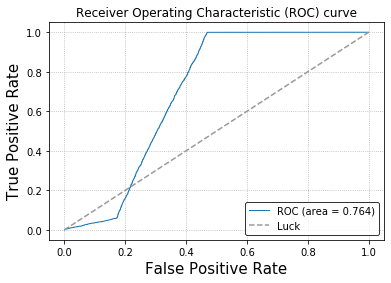

In [59]:
OCSVM_best.fit(X_train)
Y_predicted = OCSVM_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

print(classification_report(Y_eval, 
                            Y_predicted,
                            target_names=["anomalous", "normal"]))
print("Area under ROC curve: {:0.3f}".format(roc_auc))

# Compute ROC curve and area under the curve
OCSVM_probs = OCSVM_best.decision_function(X_eval)
fpr, tpr, thresholds = roc_curve(Y_eval, OCSVM_probs)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.3f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) curve', fontsize=12)
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()

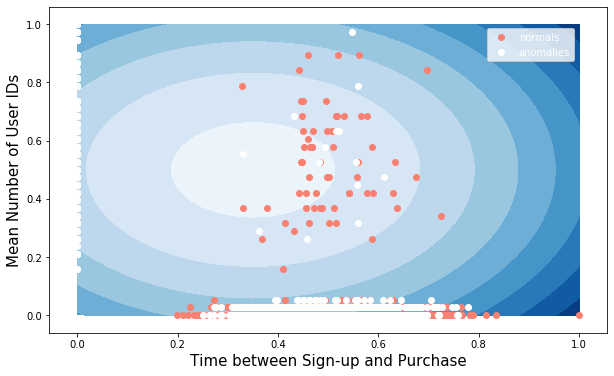

In [60]:
# Set figure size
plt.figure(figsize=(10,6))

# plot the contour lines
xx, yy = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
Z = OCSVM_best.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

# Plot normal and anomalous data
plt.scatter(X_eval[Y_eval==1].signup_to_purchase_time, X_eval[Y_eval==1].mean_number_of_userids, 
            color="salmon", label="normals")
plt.scatter(X_eval[Y_eval==-1].signup_to_purchase_time, X_eval[Y_eval==-1].mean_number_of_userids, 
            color="white", label="anomalies")

# Set labels and legend
plt.xlabel('Time between Sign-up and Purchase', fontsize=15)
plt.ylabel('Mean Number of User IDs', fontsize=15)
for text in plt.legend(bbox_to_anchor=(.95, .95)).get_texts():
    text.set_color("white")